# Amazon Review Analysis
In the following notebook, which is a part of the 4 part assignment, we will be implementing a model which does a sentiment analysis on a dataset using XGBoost + Bag of Words.

For the following we will be doing the following things:
1. Data Preprocessing
2. Making Data Machine Undersdtandable
3. XGBoost with Bag of Words
4. Evaluation and Plotting Graph

## Data Pre-processing


In [ ]:
# Data Preprocessing
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Download required NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/Machine Learning for Finances/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Machine Learning for Finances/test.csv')

# Function to clean text
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words and lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply the clean_text function to the reviewText column
train_df['cleanedText'] = train_df['reviewText'].apply(clean_text)
test_df['cleanedText'] = test_df['reviewText'].apply(clean_text)

# Separate features and target
X_train = train_df['cleanedText']
y_train = train_df['Positive']
X_test = test_df['cleanedText']
y_test = test_df['Positive']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Making Data Machine Understandable

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


## XGBoost with Bag of Words

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

In [ ]:
# Define the model
xgb_model = xgb.XGBClassifier(device='cuda')

# Define hyperparameter grid for Random Search
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Setup Random Search
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist,
                                    n_iter=10, cv=3, verbose=2,
                                    scoring='accuracy', random_state=42)

# Train the model with Random Search
random_search.fit(X_train_tfidf, y_train)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=12, n_estimators=100, subsample=0.9; total time=   1.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=12, n_estimators=100, subsample=0.9; total time=   1.5s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=12, n_estimators=100, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=12, n_estimators=50, subsample=0.8; total time=   1.5s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=12, n_estimators=50, subsample=0.8; total time=   1.7s
[CV] END colsa

## Evaluation and Plotting Graph


In [ ]:
from sklearn.metrics import f1_score

# Predict and evaluate the model
y_pred_tfidf = random_search.predict(X_test_tfidf)
print("Model Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("F1 Score:", f1_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))


Model Accuracy: 0.777
F1 Score: 0.8717285015818235
              precision    recall  f1-score   support

           0       0.88      0.08      0.15       958
           1       0.77      1.00      0.87      3042

    accuracy                           0.78      4000
   macro avg       0.82      0.54      0.51      4000
weighted avg       0.80      0.78      0.70      4000



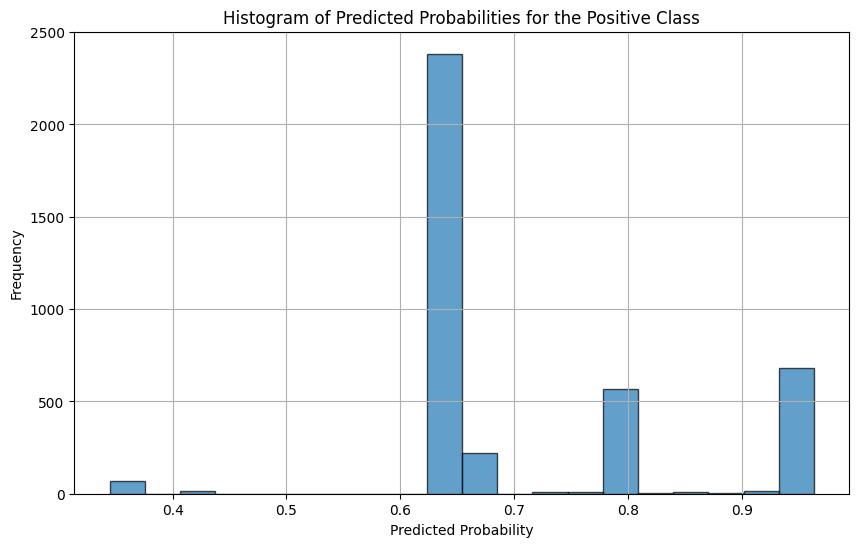

In [ ]:
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_pred_prob = random_search.predict_proba(X_test_tfidf)[:, 1]

# Plot histogram of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(y_pred_prob, bins=20, edgecolor='k', alpha=0.7)
plt.title('Histogram of Predicted Probabilities for the Positive Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Print optimized hyperparameters
print("Optimized Hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

Optimized Hyperparameters:
subsample: 0.9
n_estimators: 200
max_depth: 3
learning_rate: 0.01
colsample_bytree: 0.9
